# Prior-list intrusions

In [270]:
from __future__ import division
import numpy as np
import seaborn as sns
import quail
import pandas as pd
%matplotlib inline

# Load Data

In [225]:
man = quail.load_egg('../data/man_egg.egg')
auto = quail.load_egg('../data/auto_egg.egg')

## Function to compute prior list intrusions

In [385]:
def prior_list_intrusions(egg):
    """ 
    Computes prior list intrusions 
    
    Parameters
    __________
    
    egg : quail.Egg
        egg to analyze
        
    Returns
    _________
    
    res : numpy.ndarray
        A subject x lists back matrix containing prior lists intrusions.  
        For example, the first row is the first subject and the first 
        column is 0 lists back, the second column is 1 list back and
        so on.
        
    """

    prior_intrusions = []

    # loop over subjects
    for isub in range(egg.n_subjects):

        # get subject data
        subj = egg.crack(subjects=[isub])
        
        # initialize list
        prior_int = [[] for i in range(len(subj.pres.index.levels[1]))]

        # for each recall list
        for idx, lst in subj.rec.loc[0].iterrows():

            # for each prior list
            for iprior in range(idx+1):

                # filter out nans and nones
                lst = lst[lst.notna()]
                
                # get the list iprior back
                prior_pres = subj.pres.loc[0].loc[idx-iprior].values.tolist()

                # proportion of intrusions for a given nback, normalized by number of possible recalls
                r = lst.apply(lambda x: x in prior_pres).sum() / (idx+1)*16

                # append to the list
                prior_int[iprior].append(r)
         
        # average within nback
        s = list(map(lambda x: np.nanmean(x), prior_int))
        prior_intrusions.append(s)

    return np.array(prior_intrusions)

## Compute prior list intrusions for automatic

In [386]:
man_prior_intrusions = prior_list_intrusions(man)
auto_prior_intrusions = prior_list_intrusions(auto)

## Create a plot

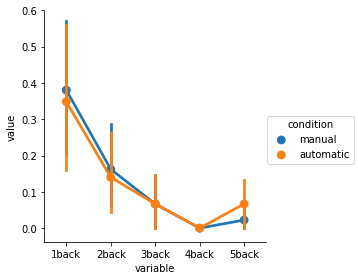

In [387]:
df_man = pd.DataFrame(man_prior_intrusions[:,1:6], columns=['1back', '2back', '3back', '4back', '5back'])
df_man['condition']='manual'
df_man['subject']=range(30)

df_auto = pd.DataFrame(auto_prior_intrusions[:,1:6], columns=['1back', '2back', '3back', '4back', '5back'])
df_auto['condition']='automatic'
df_auto['subject']=range(30)

df = pd.concat([df_man, df_auto])
df = df.melt(value_vars=['1back', '2back', '3back', '4back', '5back'], id_vars=['subject', 'condition'])

sns.factorplot(data=df, x='variable', y='value', hue='condition')

## Restructure df for correlations

In [389]:
man_tmp = df_man.melt(value_vars=['1back', '2back', '3back', '4back', '5back'], id_vars=['subject', 'condition'])
man_tmp = man_tmp.drop('condition', 1)
man_tmp = man_tmp.rename({'value':'manual'}, axis='columns')

auto_tmp = df_auto.melt(value_vars=['1back', '2back', '3back', '4back', '5back'], id_vars=['subject', 'condition'])
auto_tmp = auto_tmp.drop('condition', 1)
auto_tmp = auto_tmp.rename({'value':'automatic'}, axis='columns')

df_corr = man_tmp.merge(auto_tmp)

## Plot correlations

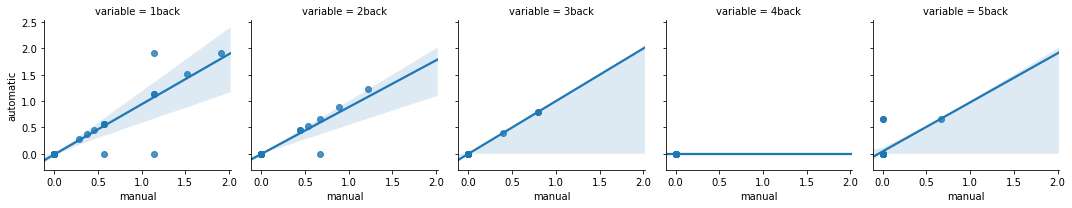

In [390]:
g = sns.FacetGrid(df_corr, col='variable')
g.map(sns.regplot, 'manual', 'automatic')